## Question-4

### Maze on fire

In [0]:
# Import libraries

import numpy as np
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import math
import queue as Q
from matplotlib.colors import ListedColormap
import time
import pprint as pp
import pandas as pd
from operator import itemgetter

In [0]:
# Function to generate maze of given dimension. It takes 'p' as the probability of a particular cell being blocked.

def generate_maze(dim = 150, p = 0.2):
    
    rows = dim
    cols = dim
    mat = np.ones((dim,dim))               # a maze with all free cells is generated
    
    for i in range(rows):
        for j in range(cols):
            if( rand.uniform(0,1) < p ):     # if random number is greater than p, an obstacle is added to the cell (i, j)
                mat[i][j] = 0
    
    mat[0][0] = 1              # start needs to be unblocked
    mat[dim-1][dim-1] = 1      # goal needs to be unblocked
    
    return mat 

In [0]:
# Function to visualize a maze

def visualise_maze(maze):
  plt.figure(figsize = (15,15))
  ax = sns.heatmap(maze, linewidths=.5, square = True, cbar=False, xticklabels=False, yticklabels=False)
  plt.show()

In [0]:
# Function to visualize the obtained path

def display_path(maze_temp, prev_list, start, goal):
  
    prev_node = goal
    path = [prev_node]
    maze_temp[prev_node] = 25        #----> green color to the goal
    
    if bool(prev_list):
      while(prev_list[prev_node] != start):
        current_node = prev_node
        prev_node = prev_list[(current_node)]
        path.append(prev_node)
        maze_temp[prev_node] = 50    #----> crimson color to the path
        
      path.append(prev_list[prev_node])
      path.reverse()
      maze_temp[prev_list[prev_node]] = 25    #----> green color to the start
      
      path_length = str(len(path))
      
      plt.figure(figsize = (15,15))
      sns.heatmap(maze_temp, cmap=ListedColormap(['black', 'green', 'crimson', 'papayawhip']), linewidths=.5,  square = True, cbar=False, xticklabels=False, yticklabels=False)
      plt.show()
      
      return path_length

In [0]:
# Function to obtain the length of a path

def path_length(goal, prev_list, start):
    
    prev_node = goal
    path = [prev_node]
    path_len = 0
    
    if bool(prev_list):
        while(prev_node in prev_list.keys() and prev_list[prev_node] != start):
            current_node = prev_node
            prev_node = prev_list[(current_node)]
            path.append(prev_node)
        
        path.append(prev_list[prev_node])
        path.reverse()

        path_len = len(path)
    
    return path_len 

In [0]:
# Function to prioritize children based on the distance to the goal. This improves DFS search

def prioritize_children(maze, goal, visited, x, y):
  
    children = []
    node = []
    h = []
    
    node.append((x+1, y))
    h.append((goal - node[0][0]) + (goal - node[0][1]))
    
    node.append((x, y+1))
    h.append((goal - node[1][0]) + (goal - node[1][1]))
    
    node.append((x-1, y))
    h.append((goal - node[2][0]) + (goal - node[2][1]))
    
    node.append((x, y-1))
    h.append((goal - node[3][0]) + (goal - node[3][1]))
    
    for i in range(4):
        ind = h.index(min(h))
        h.pop(ind)
        current_child = node.pop(ind)
        if(check_child_validity(maze,current_child,visited)):
            children.append(current_child)
    
    children.reverse()
    return children

In [0]:
# Improved function of Depth-First Search

def improved_DFS(maze, start, goal):
  
    fringe = [start]
    visited = [start]
    prev_list = {}    # To store pointers from children to their parents. It is useful for backtracking the path
    
    count_of_nodes = 0
    max_fringe_size = 0
    
    while fringe:
        (i, j) = fringe.pop()
        count_of_nodes+=1
        max_fringe_size = max( max_fringe_size, len(fringe) )
        
        if (i, j) == goal:    # to check if the goal state is found
            return 1, prev_list, count_of_nodes, max_fringe_size
           
        # Generating and adding child nodes in fringe 
        children = prioritize_children(maze,goal[0]-1,visited,i,j)    #----> Improvement
        if children:
          for c in children:
            prev_list[c] = (i,j)
            fringe.append(c)
            visited.append(c)
     
    return 0, prev_list, count_of_nodes, max_fringe_size  # No path found

In [0]:
# Function to assign heuristics to nodes

def A_star_heuristic(maze, h, goal, heuristic):    
    
    dim = maze.shape[0]
    
    for i in range(dim):
        for j in range(dim): 
            if(heuristic == "manhattan"):
                h[i][j] = ( abs(goal[0]-i) + abs(goal[1]-j) )

            if(heuristic == "euclidean"):
                h[i][j] = math.sqrt( (goal[0] - i)**2 + (goal[1]-j)**2 ) 
    

In [0]:
# Function for A* search

def A_star(maze, start, goal, heuristic):
    
    dim = maze.shape[0]
    
    h = np.zeros((dim, dim))
    g = np.zeros((dim,dim))
    f = np.zeros((dim,dim))
    
    g[start] = 0
    A_star_heuristic( maze, h, goal, heuristic)
    f = g + h
    
    visited = []
    prev_list = {}  # To store pointers from children to their parents. It is useful for backtracking the path
    
    count_of_nodes = 0
    max_fringe_size = 0
    
    fringe = Q.PriorityQueue()    # Priority queue to prioritize nodes based on cost and heuristics
    fringe.put((f[start], start))
    
    while not (fringe.empty()):
        
        
        vertex = fringe.get()[1]
        count_of_nodes+=1
        max_fringe_size = max( max_fringe_size, fringe.qsize() )
        visited.append(vertex)
        
        if vertex == goal:    # to check if the goal state is found
            return 1, prev_list, count_of_nodes, max_fringe_size, visited
        
        i = vertex[0]
        j = vertex[1] 

        # Generating and adding child nodes in fringe 
        child = create_child_nodes(maze,visited,i,j)
        if child:
            for c in child:
                prev_list[c] = vertex
                visited.append(c)
                g[c] = g[vertex] + 1
                f[c] = g[c] + h[c]
                fringe.put((f[c], c))
    
    return 0, prev_list, count_of_nodes, max_fringe_size, visited  # No path found

### Fire generation

In [0]:
# Function to generate neighbors of a cell for fire.

def generate_neighbours(cell):
  
  neighbours = []
  
  i = cell[0]
  j = cell[1]
  
  if( i+1 < dim  ):
    neighbours.append((i+1,j))
  
  if( i-1 >= 0):
    neighbours.append((i-1,j))
    
  if( j+1 < dim ):
    neighbours.append((i,j+1))
    
  if( j-1 >= 0 ):
    neighbours.append((i,j-1))
  
  return neighbours

In [0]:
# Function to spread fire for baseline.

def fire(maze, path_length, q):
  
  maze[fire_start] = -1 # Intial condition - fire on upper right corner
  
  fire_fringe = []
  fire_fringe.append((0, dim-1))
  not_on_fire_fringe = []
  new_fire = []
  n_steps = path_length
  fire_cells = []
  
  for t in range(n_steps):
    fire_cells.append([(0,dim-1)])
  
  for t in range(n_steps):

    if (fire_fringe):
      while fire_fringe:
        neighbours = generate_neighbours(fire_fringe.pop())
        while neighbours:
          neighbor = neighbours.pop()
          if maze[neighbor] != -1 and maze[neighbor] != 0 and neighbor not in not_on_fire_fringe:
            not_on_fire_fringe.append(neighbor)
    
    not_on_fire_fringe_temp = not_on_fire_fringe.copy()
    while not_on_fire_fringe_temp :
        k = 0
        cell = not_on_fire_fringe_temp.pop()
        neighbours = generate_neighbours(cell)
        
        for j in neighbours:  
          if (maze[j] == -1):
            k = k+1
        
        probability = 1 - pow(1-q, k)
        if(rand.uniform(0,1) < probability):  ##If the cell catches fire
          new_fire.append(cell) 
          not_on_fire_fringe.remove(cell)
    
    while new_fire:
      n = new_fire.pop()
      fire_fringe.append(n)
      maze[n] = -1
      for t in range(t,n_steps):
        fire_cells[t].append(n)
      
        
  return fire_cells

Basic approach in the situation where fire is spreading from top-right corner is to continue on the optimal path in the case there is no fire. This baseline approach is implemented in the function below.

In [0]:
# Function to implement the baseline condition of running the shortest path on the maze.

def baseline(dim,p,q=1):
  
  start = (0,0)
  goal = (dim-1,dim-1)

  
  is_goal_reached = 0
  is_fire_reached = 0
  
  # Generate a valid maze with paths from Top-Left to Bottom-Right (for runner) and Top-Right to Bottom-Left (for fire)
  while not is_goal_reached or not is_fire_reached:
    maze = generate_maze(dim, p)
    is_goal_reached, prev_list_path, count_of_nodes_path, max_fringe_size_path, visited_path = A_star(maze, start, goal , "manhattan")
    is_fire_reached, prev_list_fire, count_of_nodes_fire, max_fringe_size_fire, visited_fire = A_star(maze, fire_start, fire_goal, "manhattan")

  path_len, path = path_length(prev_list_path,start,goal)

  # Calculate total fire cells till length of path step 
  fire_cells = fire(np.copy(maze), path_len, q)

  for i in range(path_len):

    current_cell = path[i]
    fire_state = fire_cells[i]
    for fire_cell in fire_state:
      maze[fire_cell] = -1
    maze_temp = np.copy(maze)*100
    if current_cell != start:
      display_path(maze_temp, prev_list_path, start, current_cell)

    # check whether goal is on fire
    if goal in fire_state:   
      return 0

    # Current traversing cell is on fire
    if current_cell in fire_state:
      return 0

  # Goal reached
  if(path[i]==goal and goal not in fire_state):
    return 1

In [210]:
# Test case for baseline

dim = 50
p = 0.3
q = 0.7
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)
baseline(dim,p,q)

0

Function to determine the average success rate of this strategy as a function of q (flammibility rate). 

In [0]:
# Function to check the success rate of the baseline condition

def success_rate(dim, p, n_trials):
  
    probability_solvable = []
    
    for q in range(0, 11, 1):

        q = q/10.0
        success = 0
        
        for i in range(n_trials):
          
          output = baseline(dim,p,q)
          
          if(output == 1):
            success = success + 1    # Count the number of succesfully solved mazes
          else :
            continue
            
        probability_solvable.append(success/n_trials)
        print("Success for q = " + str(q) + " is " + str(success))

    print(probability_solvable)
    x = np.arange(0,1.1,0.1)
   
    plt.clf()
    plt.cla()
    plt.close()
    
    plt.bar(x, probability_solvable, width = 0.05 )
    
    plt.xlabel("q")
    plt.ylabel("Probability of success")
    plt.title("Density vs solvability for dim = " + str(dim) + ", #trials = "+ str(n_trials))
    plt.xticks(x)
    plt.show()

Success for q = 0.0 is 50
Success for q = 0.1 is 50
Success for q = 0.2 is 50
Success for q = 0.3 is 50
Success for q = 0.4 is 47
Success for q = 0.5 is 39
Success for q = 0.6 is 17
Success for q = 0.7 is 7
Success for q = 0.8 is 5
Success for q = 0.9 is 0
Success for q = 1.0 is 0
[1.0, 1.0, 1.0, 1.0, 0.94, 0.78, 0.34, 0.14, 0.1, 0.0, 0.0]


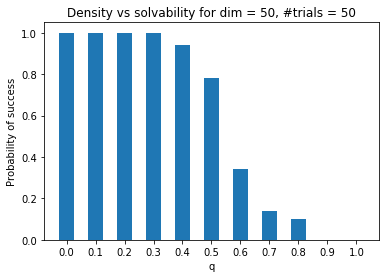

In [264]:
dim = 50
p = 0.3
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)
success_rate(dim, p, 50)

##Fire Runner

In [0]:
# Function to check whether a given child is on fire. Returns boolean

def check_child_safety(maze,vertex,visited):
    
    dim = maze.shape[0] 
    
    # If dimensions are in the range of the matrix dimensions (if cell is going out of bounds)
    if vertex[0]==-1 or vertex[1]==-1 or vertex[0]==dim or vertex[1]==dim:
        return False
      
    # If cell is on fire
    elif maze[vertex[0],vertex[1]]==-1:
        return False
    
    # Valid
    else:
        return True

In [0]:
# Function to prioritize children based on the number of neighbors on fire. This helps the fire runner.

def safe_children(maze, visited, x, y):
  
    children = []
    nodes = []
    n = []
    
    node = ((x+1, y))
    neighbors = [(x+1,y+1), (x+2,y), (x+1,y-1)]
    if(check_child_validity(maze, node, visited)):
      n.append(0)
      for i in neighbors:
        if check_child_safety(maze, i, visited):
          n[len(n)-1] += 1
        n[len(n)-1] = (dim - 1 - node[0]) + (dim - 1 - node[1]) - n[len(n)-1]    # Priority consider Manhattan distance to the goal and the number of neighbors on fire
      nodes.append(node)
    
    node = ((x, y+1))
    neighbors = [(x+1,y+1), (x,y+2), (x-1,y+1)]
    if(check_child_validity(maze, node, visited)):
      n.append(0)
      for i in neighbors:
        if check_child_safety(maze, i, visited):
          n[len(n)-1] += 1
      n[len(n)-1] = (dim - 1 - node[0]) + (dim - 1 - node[1]) - n[len(n)-1]
      nodes.append(node)
    
    node = ((x-1, y))
    neighbors = [(x-1,y+1), (x-2,y), (x-1,y-1)]
    if(check_child_validity(maze, node, visited)):
      n.append(0)
      for i in neighbors:
        if check_child_safety(maze, i, visited):
          n[len(n)-1] += 1
      n[len(n)-1] = (dim - 1 - node[0]) + (dim - 1 - node[1]) - n[len(n)-1]
      nodes.append(node)
    
    node = ((x, y-1))
    neighbors = [(x+1,y-1), (x,y-2), (x-1,y-1)]
    if(check_child_validity(maze, node, visited)):
      n.append(0)
      for i in neighbors:
        if check_child_safety(maze, i, visited):
          n[len(n)-1] += 1
      n[len(n)-1] = (dim - 1 - node[0]) + (dim - 1 - node[1]) - n[len(n)-1]
      nodes.append(node)
          
    for i in range(len(n)):
        ind = n.index(min(n))
        n.pop(ind)
        current_child = nodes.pop(ind)
        children.append(current_child)
    
    
    children.reverse()
    return children

In [0]:
# Function to prioritize children based on the distance to the goal and distance from fire. This improves the strategy of fire runner.

def save_children(maze, visited, x, y, fire_cells):
  
    children = []
    nodes = []
    h = []
    
    dist = []
    node = ((x+1, y))
    if(check_child_validity(maze, node, visited)):
      for i in fire_cells:
        dist.append((abs(i[0]-node[0]) + abs(i[1]-node[1])))    # Manhattan distance to the goal
      min_dist = 0
      if dist:
        min_dist = min(dist)
      h.append( (dim - node[0]) + (dim - node[1]) - min_dist)    # Factoring in the minimum distance from the fire
      nodes.append(node)
    
    dist = []
    node = ((x, y+1))
    if(check_child_validity(maze, node, visited)):
      for i in fire_cells:
        dist.append(abs(i[0]-node[0]) + abs(i[1]-node[1]))
      min_dist = 0
      if dist:
        min_dist = min(dist)
      h.append( (dim - node[0]) + (dim - node[1]) - min_dist)
      nodes.append(node)
    
    dist = []
    node = ((x-1, y))
    if(check_child_validity(maze, node, visited)):
      for i in fire_cells:
        dist.append(abs(i[0]-node[0]) + abs(i[1]-node[1]))
      min_dist = 0
      if dist:
        min_dist = min(dist)
      h.append( (dim - node[0]) + (dim - node[1]) - min_dist)
      nodes.append(node)
    
    dist = []
    node = ((x, y-1))
    if(check_child_validity(maze, node, visited)):
      for i in fire_cells:
        dist.append(abs(i[0]-node[0]) + abs(i[1]-node[1]))
      min_dist = 0

    
    for i in range(len(h)):
        ind = h.index(min(h))
        h.pop(ind)
        current_child = nodes.pop(ind)
        children.append(current_child)
    
    
    children.reverse()
    return children

In [0]:
# Function to implement search to stay away from all fire cells.

def fire_cell_search(maze, start, goal, fire_start, fire_goal, q):

  
  fringe = [start]
  visited = [start]
  prev_list = {}    # To store pointers from children to their parents. It is useful for backtracking the path

  count_of_nodes = 0
  max_fringe_size = 0
  
  maze[0][dim-1] = -1 # Intial condition - fire on upper right corner
  
  fire_fringe = []
  fire_fringe.append((0, dim-1))
  not_on_fire_fringe = []
  new_fire = []
  fire_cells = [(0, dim-1)]
  
  while fringe:
      maze_temp = maze*100
      (i, j) = fringe.pop()
      display_path(maze_temp, prev_list, start, (i,j))
      
      # Termination Conditions
      
      if goal in fire_cells:    # Goal is on fire
        return 3, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      if (i,j) in fire_cells:    # Runner location is on fire
        return 2, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      count_of_nodes+=1
      max_fringe_size = max( max_fringe_size, len(fringe) )

      if (i, j) == goal:    # to check if the goal state is found
          return 1, goal, prev_list, count_of_nodes, max_fringe_size, fire_cells

      # Generating and adding child nodes in fringe 
      children = save_children(maze,visited,i,j,fire_fringe)    #----> Improved DFS
      if children:
        for c in children:
          prev_list[c] = (i,j)
          fringe.append(c)
          visited.append(c)
      
      # Adding neighbors to the fringe
      if (fire_fringe):
        while fire_fringe:
          neighbours = generate_neighbours(fire_fringe.pop())
          
          while neighbours:
            neighbor = neighbours.pop()
            if maze[neighbor] != -100 and maze[neighbor] != 0 and neighbor not in not_on_fire_fringe:
              not_on_fire_fringe.append(neighbor)

      not_on_fire_fringe_temp = not_on_fire_fringe.copy()
      while not_on_fire_fringe_temp :
          k = 0
          cell = not_on_fire_fringe_temp.pop()
          neighbours = generate_neighbours(cell)

          for v in neighbours:  
            if (maze[v] == -1):
              k = k+1

          probability = 1 - pow(1-q, k)
          if( rand.uniform(0,1) < probability):  ##If the cell catches fire
            new_fire.append(cell) 
            not_on_fire_fringe.remove(cell)
      
      while new_fire:
        n = new_fire.pop()
        fire_fringe.append(n)
        maze[n] = -1
        fire_cells.append(n)

          
  return 0, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells

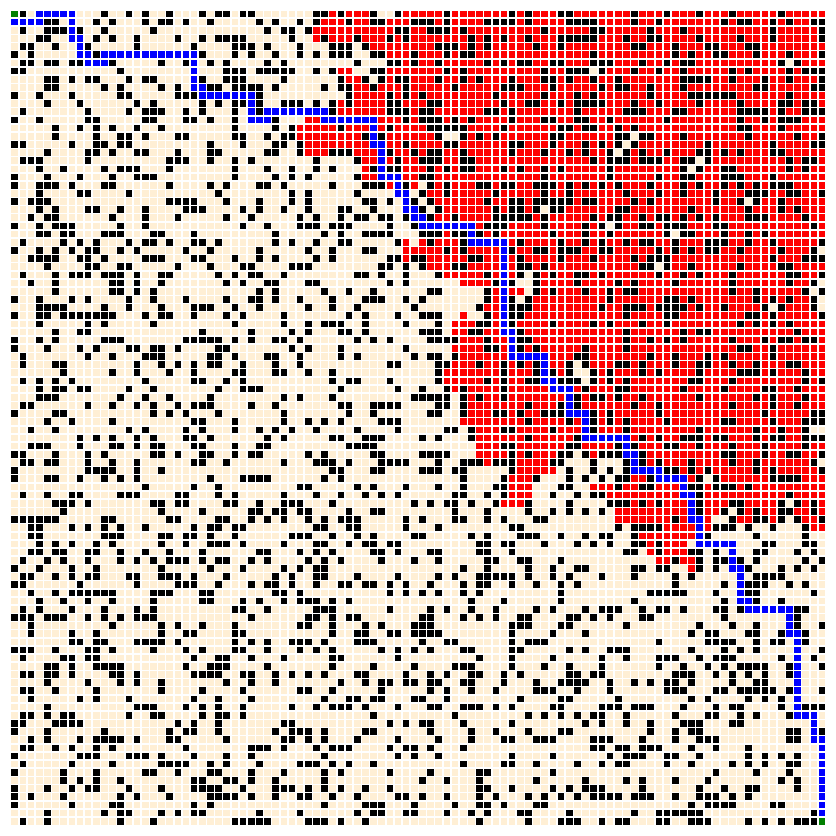

Time taken: 9.857760667800903


In [257]:
start_time = time.time()

dim = 100
p = 0.3
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)

is_goal_reached = 0
is_fire_reached = 0

while not is_goal_reached or not is_fire_reached:
  maze = generate_maze(dim, p)
  is_goal_reached, prev_list_path, count_of_nodes_path, max_fringe_size_path, visited_path = A_star(maze, start, goal , "manhattan")
  is_fire_reached, prev_list_fire, count_of_nodes_fire, max_fringe_size_fire, visited_fire = A_star(maze, fire_start, fire_goal, "manhattan")

is_reached, runner_location, prev_list, count_of_nodes, max_fringe_size, fire_cells = fire_cell_search(maze, start, goal, fire_start, fire_goal, 0.3)

maze_temp = maze*100
display_path(maze_temp, prev_list_path, start, goal)

print("Time taken: " + str(time.time()-start_time))

In [0]:
# Function to implement search to stay away from new cells on fire. 

def fire_fringe_search(maze, start, goal, fire_start, fire_goal, q):

  
  fringe = [start]
  visited = [start]
  prev_list = {}    # To store pointers from children to their parents. It is useful for backtracking the path

  count_of_nodes = 0
  max_fringe_size = 0
  
  maze[0][dim-1] = -1 # Intial condition - fire on upper right corner
  
  fire_fringe = []
  fire_fringe.append((0, dim-1))
  not_on_fire_fringe = []
  new_fire = []
  fire_cells = [(0, dim-1)]
  
  while fringe:
#       maze_temp = maze*100
      (i, j) = fringe.pop()
#       display_path(maze_temp, prev_list, start, (i,j))
      if (fire_fringe):
        while fire_fringe:
          neighbours = generate_neighbours(fire_fringe.pop())
          
          while neighbours:
            neighbor = neighbours.pop()
            if maze[neighbor] != -1 and maze[neighbor] != 0 and neighbor not in not_on_fire_fringe:
              not_on_fire_fringe.append(neighbor)

      not_on_fire_fringe_temp = not_on_fire_fringe.copy()
      while not_on_fire_fringe_temp :
          k = 0
          cell = not_on_fire_fringe_temp.pop()
          neighbours = generate_neighbours(cell)

          for v in neighbours:  
            if (maze[v] == -1):
              k = k+1

          probability = 1 - pow(1-q, k)
          if( rand.uniform(0,1) < probability):  ##If the cell catches fire
            new_fire.append(cell)
            not_on_fire_fringe.remove(cell)
      
      while new_fire:
        n = new_fire.pop()
        fire_fringe.append(n)
        maze[n] = -1
        fire_cells.append(n)

      if goal in fire_cells:
        return 3, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      if (i,j) in fire_cells:
        return 2, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      count_of_nodes+=1
      max_fringe_size = max( max_fringe_size, len(fringe) )

      if (i, j) == goal:    # to check if the goal state is found
          return 1, goal, prev_list, count_of_nodes, max_fringe_size, fire_cells

      # Generating and adding child nodes in fringe 
      children = save_children(maze,visited,i,j,fire_fringe)    #----> Improvement
      if children:
        for c in children:
          prev_list[c] = (i,j)
          fringe.append(c)
          visited.append(c)
          
  return 0, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells

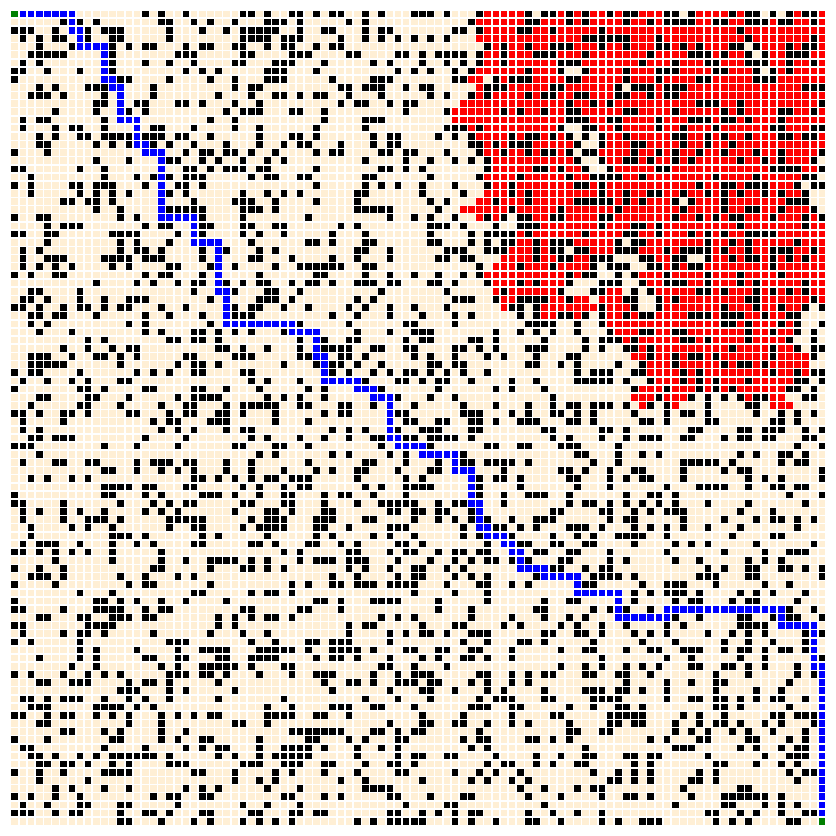

Time taken: 2.6146209239959717


In [260]:
start_time = time.time()

dim = 100
p = 0.3
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)

is_goal_reached = 0
is_fire_reached = 0

while not is_goal_reached or not is_fire_reached:
  maze = generate_maze(dim, p)
  is_goal_reached, prev_list_path, count_of_nodes_path, max_fringe_size_path, visited_path = A_star(maze, start, goal , "manhattan")
  is_fire_reached, prev_list_fire, count_of_nodes_fire, max_fringe_size_fire, visited_fire = A_star(maze, fire_start, fire_goal, "manhattan")

is_reached, runner_location, prev_list, count_of_nodes, max_fringe_size, fire_cells = fire_fringe_search(maze, start, goal, fire_start, fire_goal, 0.2)

maze_temp = maze*100
display_path(maze_temp, prev_list_path, start, goal)

print("Time taken: " + str(time.time()-start_time))

In [0]:
# Function to implement search to stay from children with more neighbors on fire.

def fire_neighbor_search(maze, start, goal, fire_start, fire_goal, q):

  
  fringe = [start]
  visited = [start]
  prev_list = {}    # To store pointers from children to their parents. It is useful for backtracking the path

  count_of_nodes = 0
  max_fringe_size = 0
  
  maze[fire_start] = -1 # Intial condition - fire on upper right corner
  
  fire_fringe = []
  fire_fringe.append((0, dim-1))
  not_on_fire_fringe = []
  new_fire = []
  fire_cells = [(0, dim-1)]
  
  while fringe:
#       maze_temp = maze*100
      (i, j) = fringe.pop()      
#       display_path(maze_temp, prev_list, start, (i,j))
      
      if goal in fire_cells:
        return 3, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      if (i,j) in fire_cells:
        return 2, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      count_of_nodes+=1
      max_fringe_size = max( max_fringe_size, len(fringe) )

      if (i, j) == goal:    # to check if the goal state is found
          return 1, goal, prev_list, count_of_nodes, max_fringe_size, fire_cells
      
      # Generating and adding child nodes in fringe 
      children = safe_children(maze,visited,i,j)    #----> Improvement
      if children:
        for c in children:
          prev_list[c] = (i,j)
          fringe.append(c)
          visited.append(c)

      if (fire_fringe):
        while fire_fringe:
          neighbours = generate_neighbours(fire_fringe.pop())
          while neighbours:
            neighbor = neighbours.pop()
            if maze[neighbor] != -1 and maze[neighbor] != 0 and neighbor not in not_on_fire_fringe:
              not_on_fire_fringe.append(neighbor)

      not_on_fire_fringe_temp = not_on_fire_fringe.copy()
      while not_on_fire_fringe_temp :
          k = 0
          cell = not_on_fire_fringe_temp.pop()
          neighbours = generate_neighbours(cell)

          for v in neighbours:  
            if (maze[v] == -1):
              k = k+1

          probability = 1 - pow(1-q, k)
          
          if( rand.uniform(0,1) < probability):  ##If the cell catches fire
            new_fire.append(cell) 
            not_on_fire_fringe.remove(cell)
          
      while new_fire:
        n = new_fire.pop()
        fire_fringe.append(n)
        maze[n] = -1
        fire_cells.append(n)
          
  return 0, (i,j), prev_list, count_of_nodes, max_fringe_size, fire_cells

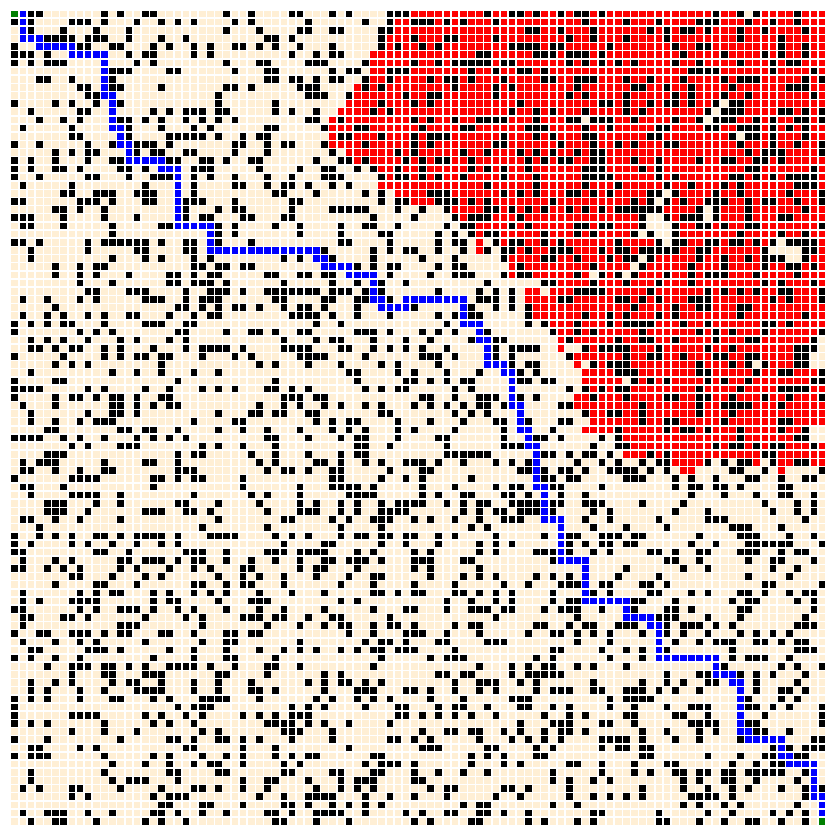

Time taken: 34.060322284698486


In [258]:
start_time = time.time()

dim = 100
p = 0.3
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)

is_goal_reached = 0
is_fire_reached = 0

while not is_goal_reached or not is_fire_reached:
  maze = generate_maze(dim, p)
  is_goal_reached, prev_list_path, count_of_nodes_path, max_fringe_size_path, visited_path = A_star(maze, start, goal , "manhattan")
  is_fire_reached, prev_list_fire, count_of_nodes_fire, max_fringe_size_fire, visited_fire = A_star(maze, fire_start, fire_goal, "manhattan")

is_reached, runner_location, prev_list, count_of_nodes, max_fringe_size, fire_cells = fire_neighbor_search(maze, start, goal, fire_start, fire_goal, 0.1)
maze_temp = maze*100
display_path(maze_temp, prev_list_path, start, goal)

print("Time taken: " + str(time.time()-start_time))

Success rate of new algorithm

In [0]:
# Function to check the success rate of the new algorithm

def success_rate_new(dim, p, n_trials):
  
    probability_solvable = []
    
    for q in range(0, 11, 1):

        q = q/10.0
        success = 0
        
        for i in range(n_trials):
          
          is_goal_reached = 0
          is_fire_reached = 0

          while not is_goal_reached or not is_fire_reached:
            maze = generate_maze(dim, p)
            is_goal_reached, prev_list_path, count_of_nodes_path, max_fringe_size_path, visited_path = A_star(maze, start, goal , "manhattan")
            is_fire_reached, prev_list_fire, count_of_nodes_fire, max_fringe_size_fire, visited_fire = A_star(maze, fire_start, fire_goal, "manhattan")

          is_reached, runner_location, prev_list, count_of_nodes, max_fringe_size, fire_cells = fire_fringe_search(maze, start, goal, fire_start, fire_goal, q)
          
          if(is_reached == 1):
            success = success + 1    # Count the number of succesfully solved mazes
          else :
            continue
            
        probability_solvable.append(success/n_trials)
        print("Success for q = " + str(q) + " is " + str(success))

    print(probability_solvable)
    x = np.arange(0,1.1,0.1)
   
    plt.clf()
    plt.cla()
    plt.close()
    
    plt.bar(x, probability_solvable, width = 0.05 )
    
    plt.xlabel("q")
    plt.ylabel("Probability of success")
    plt.title("Density vs solvability for dim = " + str(dim) + ", #trials = "+ str(n_trials))
    plt.xticks(x)
    plt.show()

Success for q = 0.0 is 42
Success for q = 0.1 is 36
Success for q = 0.2 is 34
Success for q = 0.3 is 33
Success for q = 0.4 is 13
Success for q = 0.5 is 4
Success for q = 0.6 is 0
Success for q = 0.7 is 0
Success for q = 0.8 is 0
Success for q = 0.9 is 0
Success for q = 1.0 is 0
[0.84, 0.72, 0.68, 0.66, 0.26, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0]


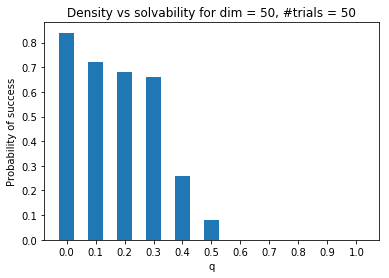

In [266]:
dim = 50
p = 0.3
start = (0,0)
goal = (dim - 1, dim - 1)
fire_start = (0,dim-1)
fire_goal = (dim-1,0)
success_rate_new(dim, p, 50)